100%|██████████| 26421880/26421880 [00:04<00:00, 5638839.72it/s] 


Extracting /.data/FashionMNIST\raw\train-images-idx3-ubyte.gz to /.data/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 103319.71it/s]


Extracting /.data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to /.data/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:02<00:00, 1778720.34it/s]


Extracting /.data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to /.data/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 5196697.23it/s]


Extracting /.data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to /.data/FashionMNIST\raw

0회


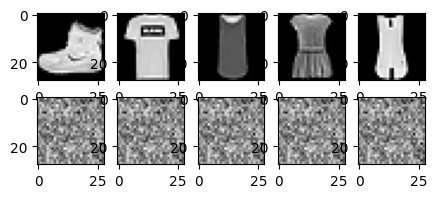

1회


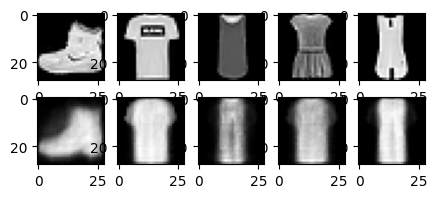

2회


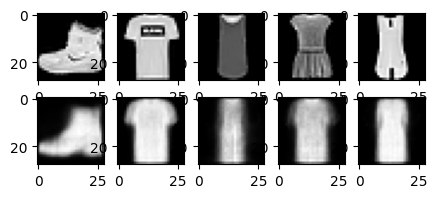

3회


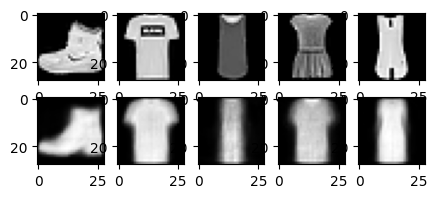

4회


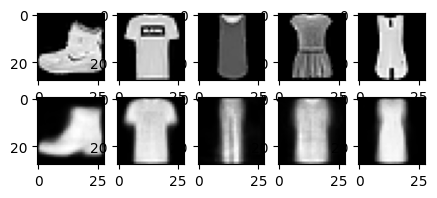

5회


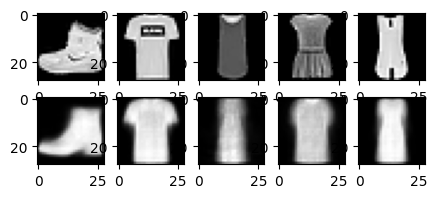

6회


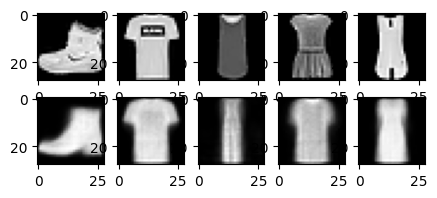

7회


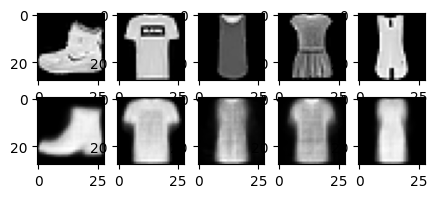

8회


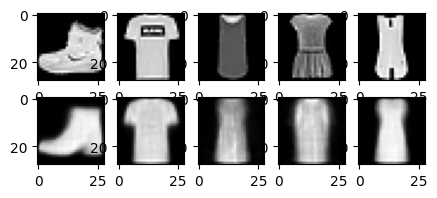

9회


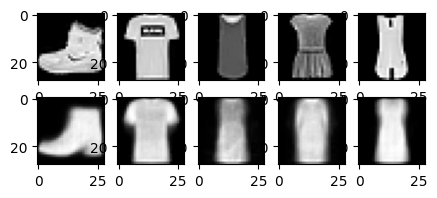

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')

from torch.utils.data import dataset
from torchvision.datasets.sbd import shutil


tr_data = datasets.FashionMNIST(
    root = '/.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
) 

tt_data = datasets.FashionMNIST(
    root = '/.data/',
    train = False,
    download = True,
    transform = transforms.ToTensor()
) 

tr_l = torch.utils.data.DataLoader(
    dataset = tr_data,
    batch_size = 64,
    shuffle = True
)

from torch.nn.modules.activation import ReLU
class Auto_E(nn.Module):
  def __init__(self):
    super().__init__()

    self.e_c_m = nn.Sequential(
          # 굳이 컨볼루션을 쓰지 않아도 된다?
          nn.Linear(28 * 28, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, 12),
          nn.ReLU(),
          nn.Linear(12, 3)
      )
    
    self.de_c_m = nn.Sequential(
          # 굳이 컨볼루션을 쓰지 않아도 된다?
          nn.Linear(3, 12),
          nn.ReLU(),
          nn.Linear(12, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, 28 * 28),
          nn.Sigmoid() # 아웃풋으로 나타낸는 화소값에 적용
      )
    
  def forward(self, x):
    ec_d = self.e_c_m(x)
    de_d = self.de_c_m(ec_d)
    return ec_d, de_d

auto_e = Auto_E().to(DEVICE)
op = torch.optim.Adam(auto_e.parameters(), lr = 0.005)
loss_f = nn.MSELoss()


v_data = tr_data.data[:5].view(-1, 28 * 28)
v_data = v_data.type(torch.FloatTensor) / 255.
# v데이터는 validation
# 오토인코더는 학습에 사용한 것만 가능이므로 학습에 사용한 데이터에서 validation

def train(m, tr_l):
  m.train()
  for i, (x, label) in enumerate(tr_l):
    x = x.view(-1, 28 * 28).to(DEVICE)
    y = x.view(-1, 28 * 28).to(DEVICE)
    label = label.to(DEVICE)
    ec_d, de_d = auto_e(x)
    
    loss = loss_f(de_d, y)
    op.zero_grad()
    loss.backward()
    op.step()

import matplotlib.pyplot as plt



for ep in range(1, 11):
  test_x = v_data.to(DEVICE)
  _, out_img = auto_e(test_x)

  # 미리 세팅
  f, ax = plt.subplots(2, 5, figsize = (5, 2))
  print(f'{ep - 1}회')
  for i in range(5):
    img = v_data.data.numpy()[i].reshape(28, 28)
    ax[0][i].imshow(img, cmap = 'gray')

  for i in range(5):
    img = out_img.data.numpy()[i].reshape(28, 28)
    ax[1][i].imshow(img, cmap = 'gray')
  plt.show()

  train(auto_e, tr_l)